# Hypothesis
1. Simulation owners apply improbability "force". 
1.1. It is constant. 
1.2. It is applied at "windows". 

How is it applied? Some parts of space start to have more improbable behavior ( Z score -> ). But the whole system has to be balanced, so some parts will have ( Z <- ) -?
The points of application will be not in RNG? Then RNG should "compensate" for that by beeing "very probable" - Z < 0.05?

Or it will "dancing close" to 0.5 expectation?

# Correlations
1. We assume that effect is strong the behavior will be syncronized. Bootstaping idea. Select 50% generators - find regions of z>0.05, check other 50% same time. if their Z is >0.05 in 5% cases -> we win.


# if for such things and solar ecclipse it has indeed local effects, than 

In [1]:
# I think that 6 hours timeslot is interesting

In [4]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import chi2
import gzip
from tqdm.notebook import trange, tqdm
import glob
import random
import seaborn as sns
from joblib import Parallel, delayed
import scipy as sp
from statsmodels.stats.proportion import proportion_confint


In [3]:
STD_200_FLIPS = math.sqrt(200)/2

In [4]:
data = pd.read_parquet('data2019.parquet')
# data.drop(['2049','2232'],axis=1,inplace=True)

In [5]:
eggs = list(set(data.columns[3:]))

In [6]:
print(data.shape, data.shape[0]/60/60/24)

(31278900, 28) 362.0243055555556


In [7]:
# there is an issue this one egg it seems - looking for it
# 
for i in range(3,data.shape[1]-3):
    tmp = (data.iloc[:,i]-100)/STD_200_FLIPS
    tmp_no_na = tmp[~np.isnan(tmp)]
    print(i, ' ',data.columns[i], tmp.mean(), 
          (data.iloc[:,i].isna().sum()/ data.shape[0])*100, 
#           np.cumsum(tmp[~np.isnan(tmp)]).iloc[-1],
          stats.binom_test((tmp_no_na>0).sum(),len(tmp_no_na)-(tmp_no_na==0).sum(),0.5))

3   1 -9.04855753439853e-05 9.014901419167554 0.8228697517392679
4   37 -0.00025007338868176447 0.027187656854940553 0.8334557276167558
5   112 0.0002967970207749757 0.030691616393159607 0.10802056346131722
6   226 0.0002726799484135822 46.872866373178084 0.5432883609104624
7   1021 0.0002949898752944855 0.334819958502377 0.07067149850565532
8   1070 2.0618740657938224e-07 47.372513099885225 0.7940335043671601
9   1092 -0.00022830272202011868 49.10773716467011 0.2844938688812735
10   1237 1.8087446459459115e-05 16.635316459338405 0.7668173125389681
11   2000 -0.0001681997460102941 0.004344781945656657 0.28460852571763384
12   2028 -7.970531928963866e-05 6.630281116023901 0.6874613314713868
13   2080 0.00018930503439899233 7.295470748651647 0.5129945973485107
14   2083 3.3318477831303945e-05 17.304700612873212 0.667700321188304
15   2178 -0.00015557768516716132 0.1276643360220468 0.6375573075205551
16   2221 0.0001282880497192171 12.395576570787336 0.4972289550268238
17   2241 -0.000165

In [8]:
STD_200_FLIPS

7.0710678118654755

In [9]:
data_std = data.std(axis=0)[3:]

In [19]:
def make_a_data_split(data, use_real_std=False):
    eggs = set(data.columns[3:])
    
    if use_real_std:
        STD_200_FLIPS = data_std
    else:
        STD_200_FLIPS = math.sqrt(200)/2
        
    
    test_eggs = list(random.sample(eggs,len(eggs)//2))
    control_eggs = list(set(eggs) - set(test_eggs))

    assert set(test_eggs) - set(control_eggs) == set(test_eggs)

    test_data = data[test_eggs]
    z_norm_test = ((test_data-100)/STD_200_FLIPS).sum(axis=1)/np.sqrt(test_data.shape[1]-test_data.isna().sum(axis=1))

    control_data = data[control_eggs]
    z_norm_control = ((control_data-100)/STD_200_FLIPS).sum(axis=1)/np.sqrt(control_data.shape[1]-control_data.isna().sum(axis=1))
    
    return z_norm_test, z_norm_control

In [20]:
z_norm_test, z_norm_control = make_a_data_split(data, use_real_std=True)

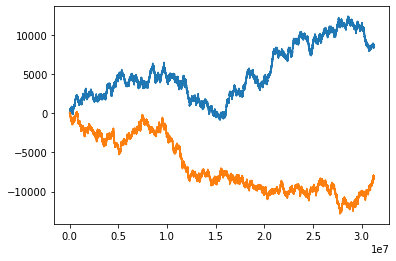

In [21]:
plt.plot(list(range(len(z_norm_test))), np.cumsum(z_norm_test**2-1))
plt.plot(list(range(len(z_norm_control))), np.cumsum(z_norm_control**2-1))

In [22]:
def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

In [23]:
z_norm_test

index
0        1.609872
1       -0.983636
2        0.134559
3        0.402465
4       -0.804795
           ...   
86395   -0.750282
86396    1.099878
86397    1.149703
86398    0.249310
86399    0.799573
Length: 31278900, dtype: float64

# Idea 1.

The direction of Z-score change will correlate. We can analyse by splitting in chunk, or having sliding windows scan.
P.S. Side note - this is mostly sanity check. I don't think DIRECTION actually matters as per original motivation behind XOR approach.

### splits hypothesis

In [24]:
r = np.sign(np.array(z_norm_control).reshape(-1,1).cumsum(axis=1)[:,-1]) == \
            np.sign(np.array(z_norm_test).reshape(-1,1).cumsum(axis=1)[:,-1])

In [25]:
np.array(z_norm_control).reshape(-1,1).cumsum(axis=1).shape

(31278900, 1)

In [26]:
r.mean()

0.4999492309512163

In [28]:
result = []

for iteration in tqdm(range(5)):
    z_norm_test, z_norm_control = make_a_data_split(data, use_real_std=True)
    for divisor in tqdm(list(divisorGenerator(z_norm_control.shape[0]))):
        divisor=int(divisor)
        zc = np.array(z_norm_control).reshape(-1,divisor).cumsum(axis=1)[:,-1]
        zt = np.array(z_norm_test).reshape(-1,divisor).cumsum(axis=1)[:,-1]
        
        r = np.sign(zc) == \
            np.sign(zt)
        r = r[~((np.isnan(zc)) | (np.isnan(zt)) | (zc==0) | (zt==0))]
        result.append({'it':iteration, 'div':divisor, 'p':stats.binom_test(r.sum(),len(r),0.5,'two-sided')})


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

<AxesSubplot:xlabel='div', ylabel='p'>

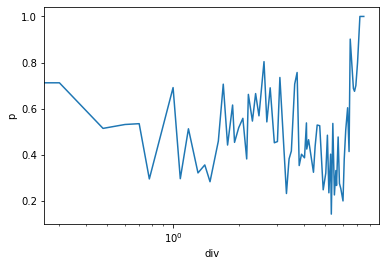

In [29]:
tmp = pd.DataFrame(result).groupby('div').mean()
tmp = tmp.reset_index()
f, ax = plt.subplots()
ax.set(xscale='log')
sns.lineplot(x=tmp['div'],y=tmp['p'])

Ok, sanity passed, nothing unexpected in general. 

## Idea 2. Moments of High Z score ( irrespectfull of direction ) are correlated

In [30]:
list(divisorGenerator(z_norm_control.shape[0]))[:38]

[1,
 2,
 3,
 4,
 5,
 6,
 10,
 12,
 15,
 20,
 25,
 30,
 41,
 50,
 60,
 75,
 82,
 100,
 123,
 150,
 164,
 205,
 246,
 300,
 410,
 492,
 615,
 820,
 1025,
 1230,
 2050,
 2460,
 2543,
 3075,
 4100,
 5086,
 6150.0,
 7629.0]

In [13]:
thrs = [0.15, 0.1, 0.05, 0.025, 0.01,0.0075, 0.005, 0.0025, 0.001]

In [31]:
# TODO Make this computation parallel
# Todo account for standart deviations
# check on another year
# find a "opportunity window" and scan with sliding window

result = []
for iteration in tqdm(range(50)):
    z_norm_test, z_norm_control = make_a_data_split(data, use_real_std=True)
    z_norm_control = np.array(z_norm_control)**2
    z_norm_test = np.array(z_norm_test)**2
    
    for divisor in list(divisorGenerator(z_norm_control.shape[0]))[:40]:
        divisor = int(divisor)
        
        zc_raw = z_norm_control.reshape(-1,divisor).cumsum(axis=1)[:,-1]
        zt_raw = z_norm_test.reshape(-1,divisor).cumsum(axis=1)[:,-1]
        
        for thr in thrs:
            control_probas = stats.chi2.sf(zc_raw,df=divisor)
            r1 = ~((np.isnan(zc_raw)) | (zc_raw==0)| (zt_raw==0)|(np.isnan(zt_raw))) & (control_probas<thr)
            
            q=(control_probas<thr).mean()
            r2 = ~((np.isnan(zc_raw)) | (zc_raw==0)| (zt_raw==0)|(np.isnan(zt_raw))) & (np.random.choice(a=[False, True], size=control_probas.shape, p=[1-q,q]))
            
            
            test_probas = stats.chi2.sf(zt_raw[r1],df=divisor)
            second_control =stats.chi2.sf(zt_raw[r2],df=divisor)

            result.append({    'it':iteration, 
                               'div':divisor, 
                               'thr':thr,
                               'mean':test_probas.mean(),
                               'std':test_probas.std(),
                               'median':np.median(test_probas),
                               'raw_values':test_probas,
                               'mean2':second_control.mean(),
                               'std2':second_control.std(),
                               'median2':np.median(second_control),
                               'raw_values2':second_control})
    

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-31-b7c4d619d03d>:36: RuntimeWarning: Mean of empty slice.
  'mean2':second_control.mean(),
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
<ipython-input

In [32]:
tmp = pd.DataFrame(result)

In [35]:
tmp.to_pickle('results.pickle')

In [6]:
tmp = pd.read_pickle('results.pickle')

In [7]:
tmp['m1_ci']=1.96*tmp['std']/np.sqrt(tmp['div'].shape[0])
tmp['m2_ci']=1.96*tmp['std2']/np.sqrt(tmp['div'].shape[0])

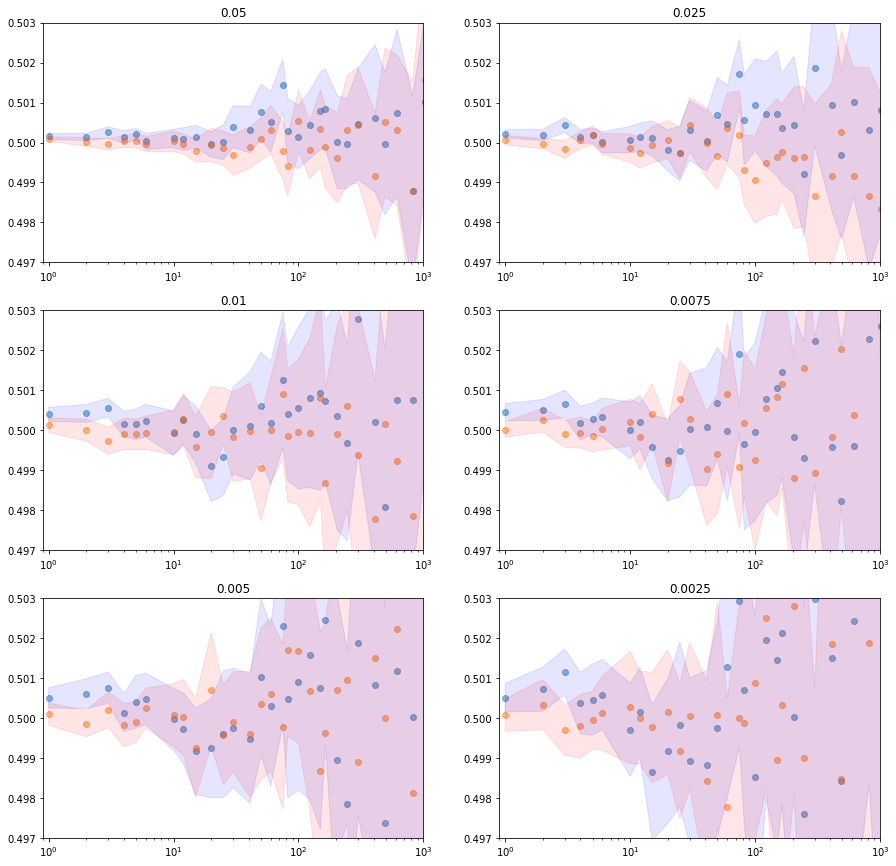

In [34]:
fig, axs = plt.subplots(3, 2,figsize=(15,15))

i = 0
for ax_x in axs:
    for ax in ax_x:
        
        q = tmp[tmp['thr']==thrs[i]]
        ci = q.groupby(['div']).std()/math.sqrt(30)*1.96
        q = q.groupby('div').mean()
        ax.scatter(q.index, q['mean'], alpha=0.5)
        ax.scatter(q.index, q['mean2'], alpha=0.5)
        ax.fill_between(q.index, (q['mean']-ci['mean']), (q['mean']+ci['mean']), color='b', alpha=.1)
        ax.fill_between(q.index, (q['mean2']-ci['mean2']), (q['mean2']+ci['mean2']), color='r', alpha=.1)
        ax.set_xscale('log')
        ax.set_ylim([0.497,0.503])
        ax.set_xlim([0.9,1000])
        ax.set_title(thrs[i])
        
        i+=1

In [31]:
tmp['size_vec']=tmp.raw_values.apply(lambda x: len(x))

In [32]:
tmp.groupby(['div','thr']).mean().size_vec

div    thr   
1      0.0010     31383.08
       0.0025     78267.22
       0.0050    159999.26
       0.0075    239520.32
       0.0100    312207.72
                   ...    
12300  0.0050        12.42
       0.0075        18.78
       0.0100        24.84
       0.0250        65.28
       0.0500       127.62
Name: size_vec, Length: 280, dtype: float64

<ipython-input-9-dec4e013e8dc>:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,1000])


(0.6244601721267029, 1000)

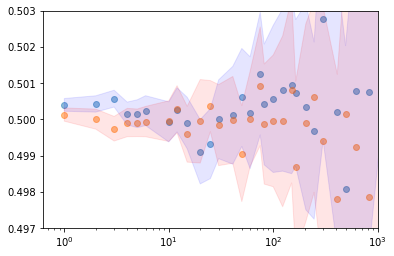

In [21]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="b", alpha=.1)

    return ax

def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
#         print(xs.shape,ys.shape,resid.shape, resamp_resid.shape)
        # Make coeffs of for polys
        pc = np.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, np.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))

    return ax

def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

# y_model = equation(p, q.index)     

<AxesSubplot:>

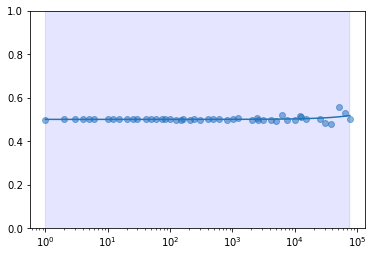

In [22]:
q = tmp[tmp['thr']==0.01].groupby('div').mean()
q = q[q.index<1e5]

x=q.index[~np.isnan(q['mean'])]
y=q[~np.isnan(q['mean'])]['mean']
p, cov = np.polyfit(x, y, 1, cov=True)

y_model = equation(p, x)   

# Statistics
n = x.shape[0]                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.95, n - m)   


x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Estimates of Error in Data/Model
resid = x - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error


            
plt.scatter(x, y, alpha=0.5)
plt.plot(x, y_model)
plt.xscale('log')
plt.ylim([0.,1])




plot_ci_manual(t, s_err, n, x, x2, y2)
# plot_ci_bootstrap(x, y, resid)

# q = tmp[tmp['thr']==0.01].groupby('div').mean()
# # q = q[q.index<1e6]
# x=q.index[~np.isnan(q['mean2'])]
# y=q[~np.isnan(q['mean2'])]['mean2']
# p, cov = np.polyfit(q.index[~np.isnan(q['mean2'])], q[~np.isnan(q['mean2'])]['mean2'], 3, cov=True)

# y_model = equation(p, q.index)   

# # Statistics
# n = q.shape[0]                                           # number of observations
# m = p.size                                                 # number of parameters
# dof = n - m                                                # degrees of freedom
# t = stats.t.ppf(0.95, n - m)   


# x2 = np.linspace(np.min(x), np.max(x), 100)
# y2 = equation(p, x2)

# # Estimates of Error in Data/Model
# resid = q['mean2'] - y_model                           
# chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
# chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
# s_err = np.sqrt(np.sum(resid**2) / dof)  

# plt.scatter(q.index, q['mean2'], alpha=0.5)
# plt.plot(q.index, y_model)

# # plot_ci_manual(t, s_err, n, x, x2, y2)
# plot_ci_bootstrap(x, y, resid)

In [23]:
resid

Float64Index([0.5004291192945887, 1.5004288883124983,  2.500428657330408,
               3.500428426348318, 4.5004281953662275,  5.500427964384137,
               9.500427040455776, 11.500426578491595, 14.500425885545324,
              19.500424730634872, 24.500423575724422,  29.50042242081397,
               40.50041988001097,  49.50041780117216,  59.50041549135126,
                74.5004120266199,  81.50041040974527,  99.50040625206765,
              122.50040093947956, 149.50039470296312, 163.50039146921387,
              204.50038199894817, 245.50037252868245,  299.5003600556496,
              409.50033464761964, 491.50031570708825,  614.5002872962912,
               819.5002399449626,  1024.500192593634, 1229.5001452423055,
              2049.4999558369914, 2459.4998611343344,  2542.499841962821,
              3074.4997190803488,  4099.499482323707,  5085.499254575365,
               6149.499008810421,   7628.49866718791, 10171.498079800454,
              12299.497588270566, 1271

In [24]:
rrr = []
for i in tmp['div'].unique():
    q = tmp[(tmp['thr']==0.05)&(tmp['div']==i)]
    try:
        rrr.append({'i':i,
                'm1':stats.ks_2samp(q['median'], q['median']).pvalue,
                'm2':stats.ks_2samp(np.concatenate([i for i in q['raw_values']]), np.concatenate([i for i in q['raw_values2']])).pvalue})
    except:
        pass
    
#     print(stats.ks_2samp(np.concatenate([i for i in q['raw_values']]), np.concatenate([i for i in q['raw_values2']])))
#     print(stats.ks_2samp(q['mean'], q['mean2']).pvalue)

In [25]:
rrr1=pd.DataFrame(rrr)
rrr1
# plt.scatter(rrr1['i'], rrr1['m2'], alpha=0.5)
# plt.scatter(rrr1['i'], rrr1['m1'], alpha=0.5)
# plt.xscale('log')

,i,m1,m2
0,1,1.0,0.065029
1,2,1.0,0.475523
2,3,1.0,0.002092
3,4,1.0,0.660099
4,5,1.0,0.091192
...,...,...,...
65,3127890,1.0,0.023089
66,5213150,1.0,0.895272
67,6255780,1.0,0.949787
68,7819725,1.0,0.905926


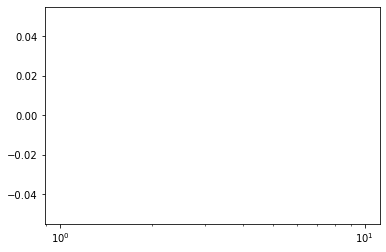

In [26]:
plt.scatter(q.index, q['mean'], alpha=0.5)
plt.scatter(q.index, q['mean2'], alpha=0.5)
plt.xscale('log')
# plt.ylim([0.495,0.5025])

In [288]:
stats.binom_test(473,len(tmp_no_na)-(tmp_no_na==0).sum(),0.5))

0      -0.342493
1      -0.310172
2      -0.282719
3      -0.313946
4      -0.283553
          ...   
5125   -0.335033
5126   -0.335033
5127   -0.382791
5128   -0.382791
5129   -0.382791
Length: 5130, dtype: float64

In [286]:
tmp[tmp['thr']==0.05].groupby('div').mean()

,it,thr,mean,std,median
div,,,,,
4,14.5,0.05,0.473052,0.287885,0.461180
5,14.5,0.05,0.480094,0.287830,0.471438
6,14.5,0.05,0.484992,0.287861,0.478482
10,14.5,0.05,0.494458,0.288218,0.492095
12,14.5,0.05,0.496224,0.288326,0.494654
15,14.5,0.05,0.497584,0.288452,0.496572
20,14.5,0.05,0.498399,0.288533,0.497738
25,14.5,0.05,0.498739,0.288569,0.498243
30,14.5,0.05,0.498902,0.288563,0.498452


Ok, now I want to work out sliding window approach. Based on GCP main experiment, they observed fluctuations in
around 6-24 hours range. We are going to monitor 6 12 24 hours sliding windows.

Plus based on previous analysis we "see" few other candidantes - 60 seconds

In [516]:
list(range(1,5,2))

[1, 3]

In [ ]:
result = []
INTERVAL = 3
for i in tqdm(range(0,z_norm_test.shape[0]-INTERVAL-1,INTERVAL)):
    sign_test_positive = False 
    q_test = z_norm_test.iloc[i:i+INTERVAL]
    if np.cumsum(q_test).iloc[-1]>0:
        sign_test_positive = True
        
    sign_control_positive = False
    q_control = z_norm_control.iloc[i:i+INTERVAL]
    if np.cumsum(q_control).iloc[-1]>0:
        sign_control_positive = True
    result.append(1 if sign_test_positive==sign_control_positive else 0)
    

    
result = np.array(result)

AttributeError: 'list' object has no attribute 'sum'

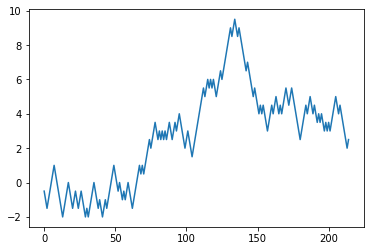

In [544]:
plt.plot(list(range(len(result))), np.cumsum(result-0.5))

In [508]:
z_norm_test.iloc[i:i+INTERVAL]

index
85400   -0.389335
85401    0.940893
85402    1.622230
85403   -1.135561
85404    0.811115
           ...   
85895    0.778670
85896   -0.194668
85897   -1.979120
85898   -0.129778
85899   -0.519114
Length: 500, dtype: float64

In [509]:
z_norm_control.iloc[i:i+INTERVAL]

index
85400   -0.600006
85401   -1.166678
85402   -0.266669
85403    1.800017
85404   -0.500005
           ...   
85895    0.333337
85896    0.600006
85897    1.100011
85898    0.866675
85899    1.266679
Length: 500, dtype: float64

In [575]:
np.array(z_norm_control).reshape(-1,120).cumsum(axis=1).shape

(21600, 120)

In [596]:
np.array(z_norm_control).reshape(-1,120).cumsum(axis=1)[:,-1]

array([ -0.98031548,  -2.24523867,   9.39205472, ...,   1.23334516,
        10.46676704, -18.93351491])

In [598]:
np.array(z_norm_test).reshape(-1,120).cumsum(axis=1)[:,-1]

array([-6.75710906,  6.68850896, -3.97880533, ..., -1.20045003,
       11.97205569, 14.92451387])

In [600]:
r = np.sign(np.array(z_norm_control).reshape(-1,120).cumsum(axis=1)[:,-1]) == np.sign(np.array(z_norm_test).reshape(-1,120).cumsum(axis=1)[:,-1])

In [601]:
r.mean()

0.4986111111111111

In [605]:
INTERVAL=120
q= np.array(z_norm_control).cumsum()
scores = []

for i in tqdm(range(0,len(z_norm_control)-INTERVAL,1)):
    scores.append(q[i+INTERVAL]-q[i])

  0%|          | 0/2591880 [00:00<?, ?it/s]

In [609]:
max(scores)

49.59357228245504

In [611]:
min(scores)

-53.85238558362357

In [ ]:
# second hypothesis would be after high Z - is should be compensated by low Z, so it will not follow the "normal distribution"